In [1]:
import sys
sys.path.append('../utils/')

In [2]:
from Bias_Variance_Estimator import estimate_bias_variance_0_1

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# -----------------------------
# 1. Load dataset (digits 8x8 images, 10 classes)
# -----------------------------
digits = load_digits()
X = digits.data.astype(np.float32)   # shape (1797, 64)
y = digits.target.astype(np.int64)

In [4]:
digits

{'data': array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ..., 16.,  9.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  2., ..., 12.,  0.,  0.],
        [ 0.,  0., 10., ..., 12.,  1.,  0.]]),
 'target': array([0, 1, 2, ..., 8, 9, 8]),
 'frame': None,
 'feature_names': ['pixel_0_0',
  'pixel_0_1',
  'pixel_0_2',
  'pixel_0_3',
  'pixel_0_4',
  'pixel_0_5',
  'pixel_0_6',
  'pixel_0_7',
  'pixel_1_0',
  'pixel_1_1',
  'pixel_1_2',
  'pixel_1_3',
  'pixel_1_4',
  'pixel_1_5',
  'pixel_1_6',
  'pixel_1_7',
  'pixel_2_0',
  'pixel_2_1',
  'pixel_2_2',
  'pixel_2_3',
  'pixel_2_4',
  'pixel_2_5',
  'pixel_2_6',
  'pixel_2_7',
  'pixel_3_0',
  'pixel_3_1',
  'pixel_3_2',
  'pixel_3_3',
  'pixel_3_4',
  'pixel_3_5',
  'pixel_3_6',
  'pixel_3_7',
  'pixel_4_0',
  'pixel_4_1',
  'pixel_4_2',
  'pixel_4_3',
  'pixel_4_4',
  'pixel_4_5',
  'pixel_4_6',
  'pixel_4_7',
  'pixel_5_0',
  'pixel_5_1',
 

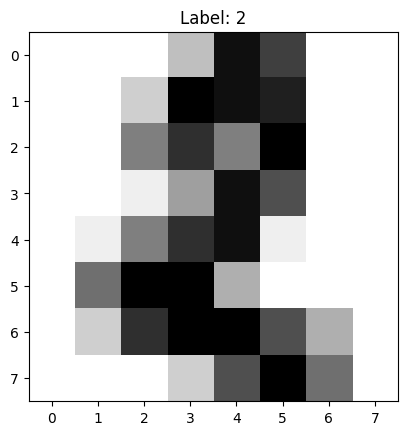

In [5]:
import matplotlib.pyplot as plt

image_index = 2

image_data = digits.data[image_index].reshape(8, 8)

plt.imshow(image_data, cmap=plt.cm.gray_r, interpolation='nearest')

plt.title(f'Label: {digits.target[image_index]}')

# Show the plot
plt.show()

In [6]:
X.shape

(1797, 64)

In [7]:
y.shape

(1797,)

In [8]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [9]:
class MLP(nn.Module):
    def __init__(self, input_dim=64, hidden_dim=128, output_dim=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)   # logits (not softmax)
        )
    def forward(self, x):
        return self.net(x)

In [10]:
hidden_unit_sizes = [1,8,16,64,128,256,512,1024,2048,4096,8192]
results=[]
for hidden_unit in hidden_unit_sizes:
    print(f"training with hidden unit {hidden_unit}")
    avg_bias, avg_var, avg_exp_loss, empirical_01_loss,avg_train_loss, _ =estimate_bias_variance_0_1(
        model_class=MLP,
        loss_fn = nn.CrossEntropyLoss(),
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        model_kwargs={'input_dim': X_train.shape[1],'hidden_dim':hidden_unit},
        num_models=20,
        max_epochs=500,
        patience=500,
        lr=0.001,
    )
    results.append({
            'hidden_units': hidden_unit,
            'bias': avg_bias,
            'variance': avg_var,
            'avg_exp_loss': avg_exp_loss,
            'empirical_01_loss': empirical_01_loss,
            'avg_train_loss':avg_train_loss
        })

training with hidden unit 1
Starting experiment with 20 models...

--- Training Model 1/20 ---

--- Training Model 2/20 ---

--- Training Model 3/20 ---

--- Training Model 4/20 ---

--- Training Model 5/20 ---

--- Training Model 6/20 ---

--- Training Model 7/20 ---

--- Training Model 8/20 ---

--- Training Model 9/20 ---

--- Training Model 10/20 ---

--- Training Model 11/20 ---

--- Training Model 12/20 ---

--- Training Model 13/20 ---

--- Training Model 14/20 ---

--- Training Model 15/20 ---

--- Training Model 16/20 ---

--- Training Model 17/20 ---

--- Training Model 18/20 ---

--- Training Model 19/20 ---

--- Training Model 20/20 ---

--- Final 0-1 Loss Decomposition Results ---
Average Bias         : 0.5444
Average Variance     : 0.7406
Expected 0-1 Loss    : 0.7894
Expected 0-1 Loss paper   : 0.4569
Empirical 0-1 Loss   : 0.7894
Bias - Variance?     : -0.1961 
training with hidden unit 8
Starting experiment with 20 models...

--- Training Model 1/20 ---

--- Training M

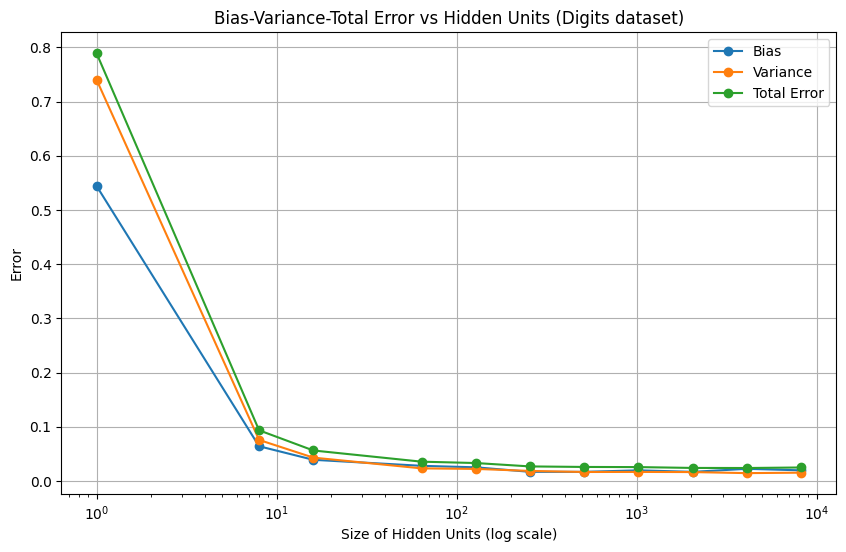

In [28]:
bias = [r['bias'] for r in results]
variance = [r['variance'] for r in results]
total_error = [r['avg_exp_loss'] for r in results]
avg_train_loss = [np.mean(r['avg_train_loss'],axis=0) for r in results]

# --- Plot 1: Bias, Variance, Total Error ---
plt.figure(figsize=(10, 6))
plt.plot(hidden_unit_sizes, bias, marker='o', label='Bias')
plt.plot(hidden_unit_sizes, variance, marker='o', label='Variance')
plt.plot(hidden_unit_sizes, total_error, marker='o', label='Total Error')
plt.xscale('log')  # Log scale for hidden units
plt.xlabel('Size of Hidden Units (log scale)')
plt.ylabel('Error')
plt.title('Bias-Variance-Total Error vs Hidden Units (Digits dataset)')
plt.legend()
plt.grid(True)
plt.show()

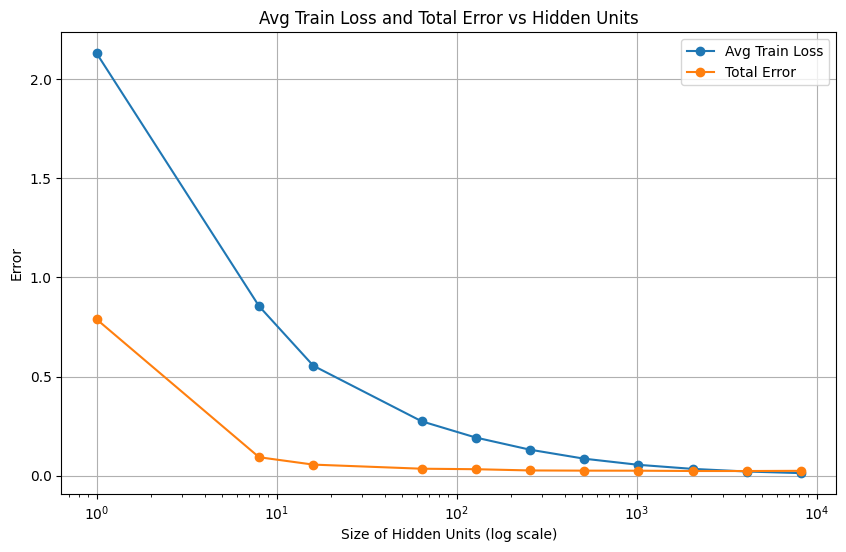

In [26]:
plt.figure(figsize=(10, 6))
train_loss = mean_loss = np.mean(avg_train_loss, axis=0)
plt.plot(hidden_unit_sizes, avg_train_loss, marker='o', label='Avg Train Loss')
plt.plot(hidden_unit_sizes, total_error, marker='o', label='Total Error')
plt.xscale('log')  # Log scale for hidden units
plt.xlabel('Size of Hidden Units (log scale)')
plt.ylabel('Error')
plt.title('Avg Train Loss and Total Error vs Hidden Units')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
len(train_loss)

10000

In [22]:
len(total_error)

11

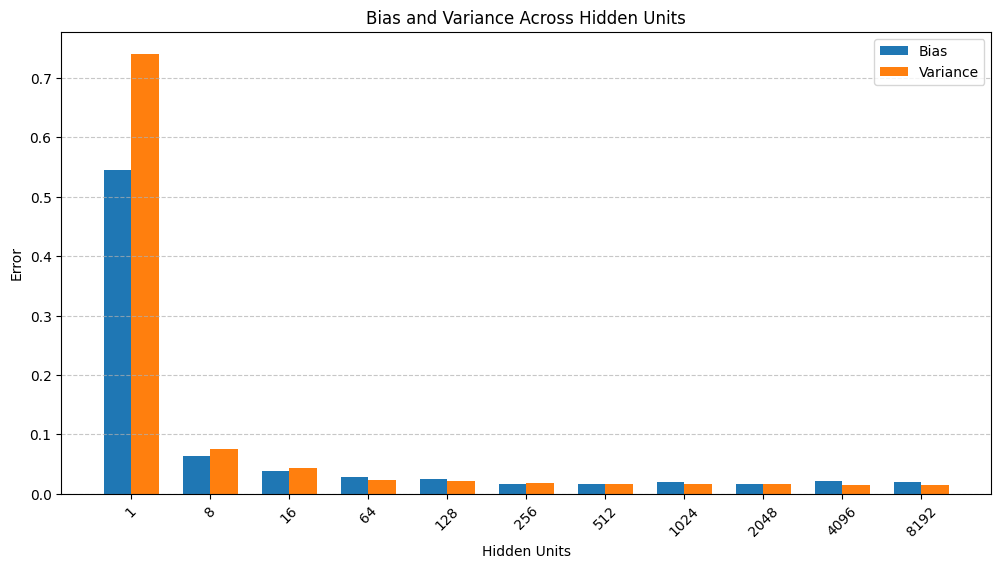

In [29]:
bias = [r['bias'] for r in results]
variance = [r['variance'] for r in results]


x = np.arange(len(hidden_unit_sizes))  
width = 0.35  
plt.figure(figsize=(12, 6))
plt.bar(x - width/2, bias, width, label='Bias')
plt.bar(x + width/2, variance, width, label='Variance')


plt.xticks(x, hidden_unit_sizes, rotation=45)
plt.xlabel('Hidden Units')
plt.ylabel('Error')
plt.title('Bias and Variance Across Hidden Units')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()